In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [2]:
#Best hyperparameters: {'lr': 5.044450031349452e-05, 
# 'num_layers': 3, 
# 'n_units_l0': 25, 
# 'n_units_l1': 90, 
# 'n_units_l2': 56}

class DynamicRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DynamicRegressionModel, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        
        for i in range(1, len(hidden_sizes)):
            layers += [nn.Linear(hidden_sizes[i-1], hidden_sizes[i]), nn.ReLU()]
        
        layers += [nn.Linear(hidden_sizes[-1], output_size)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_size):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_size, batch_size*hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(batch_size*hidden_size, batch_size)
        self.output_layer = nn.Linear(batch_size, output_size)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x


In [3]:
COLS_TO_DROP = ['prune_name','rgft_name','orig_ds_ll','ll_prune','time_prune',
                'd_ll_prune', 'orig_ds_id','ll_rgft','time_rgft', 'd_ll_merged',                 
                'name2ntaxa_pruned_prune','name2ntaxa_remaining_prune',
                'name2ntaxa_pruned_rgft','name2ntaxa_remaining_rgft']

#COLS_TO_DROP = ['prune_name','rgft_name','orig_ds_ll','ll_prune','time_prune',
#                'd_ll_prune', 'orig_ds_id','ll_rgft','time_rgft', 'd_ll_merged']

TARGET_COL = 'd_ll_merged'

file_path = './data/training_data/learning_all_moves.csv'
df = pd.read_csv(file_path, index_col='iteration', low_memory=False)


In [4]:
groups = df['orig_ds_id']
print(f'Are present {len(groups.unique())} different datasets')
data = df.drop(COLS_TO_DROP, axis=1)

labels = df[TARGET_COL].values
features = data.values

# Normalize features
#scaler = StandardScaler()
scaler = RobustScaler()
features_scaled = scaler.fit_transform(features)

# Convert to PyTorch tensors
features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

Are present 1798 different datasets


Epoch [1/100], Loss: 207391.3281, AVGLoss: 34378.2007
Epoch [2/100], Loss: 55030.0039, AVGLoss: 27237.7619
Epoch [3/100], Loss: 3618.9834, AVGLoss: 23427.8533
Epoch [4/100], Loss: 11557.0127, AVGLoss: 21891.2569
Epoch [5/100], Loss: 13172.3076, AVGLoss: 21271.4392
Epoch [6/100], Loss: 20651.7910, AVGLoss: 20911.6585
Epoch [7/100], Loss: 5989.9360, AVGLoss: 20636.0724
Epoch [8/100], Loss: 11788.6025, AVGLoss: 20373.0984
Epoch [9/100], Loss: 4917.2944, AVGLoss: 20102.7427
Epoch [10/100], Loss: 37576.8125, AVGLoss: 19860.9580
Epoch [11/100], Loss: 11553.4209, AVGLoss: 19642.1854
Epoch [12/100], Loss: 9925.3711, AVGLoss: 19444.9938
Epoch [13/100], Loss: 27660.3965, AVGLoss: 19251.3919
Epoch [14/100], Loss: 27694.5605, AVGLoss: 19049.8852
Epoch [15/100], Loss: 8718.8760, AVGLoss: 18840.4437
Epoch [16/100], Loss: 27112.8750, AVGLoss: 18618.3861
Epoch [17/100], Loss: 14147.4336, AVGLoss: 18376.5390
Epoch [18/100], Loss: 15978.4609, AVGLoss: 18107.1255
Epoch [19/100], Loss: 7263.8276, AVGLoss:

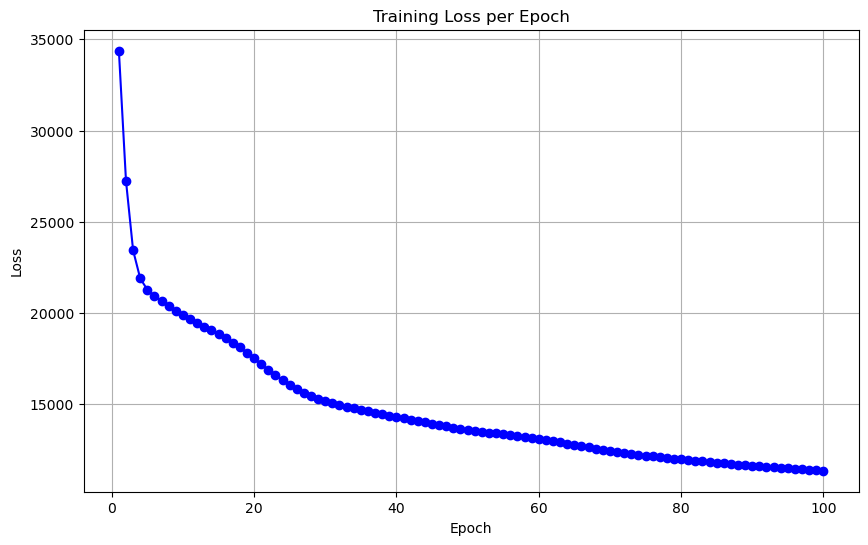

" model.eval()  # Set the model to evaluation mode\nwith torch.no_grad():\n\tpredictions = []\n\tactuals = []\n\tfor X_batch, y_batch in val_loader:\n\t\ty_pred = model(X_batch)\n\t\tpredictions.append(y_pred.numpy())\n\t\tactuals.append(y_batch.numpy())\n\n\t# Flatten the list if predictions and actuals are nested lists\n\tpredictions = np.concatenate(predictions, axis=0)\n\tactuals = np.concatenate(actuals, axis=0)\n\n\t# Calculate the MSE for the current fold\n\tmae = mean_absolute_error(actuals, predictions)\n\tmse = mean_squared_error(actuals, predictions)\n\tr2 = r2_score(actuals, predictions)\n\tprint(f'MAE: {mae}, MSE: {mse}, R^2: {r2}') "

In [8]:

BATCH_SIZE = 64
HIDDEN_SIZE = 2 
OUTPUT_SIZE = 1  # predicting 'd_ll_merged' value
NUM_EPOCHS = 100

#X_train, X_test, y_train, y_test = train_test_split(features_tensor, labels_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(features_tensor, labels_tensor)
#val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
#                            torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)

input_size = features_tensor.shape[1]  # Number of features
#model = RegressionModel(input_size, HIDDEN_SIZE, OUTPUT_SIZE, BATCH_SIZE)  # Re-instantiate model for each fold
model = DynamicRegressionModel(input_size, [25, 90, 56], OUTPUT_SIZE)  # Re-instantiate model for each fold
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=5.044450031349452e-05)

# Reset loss_values or define a new one for each fold if you want to track per fold
loss_values = []

# Training loop for the current fold
# Similar to your existing loop, but you may also want to add validation logic here
num_epochs = NUM_EPOCHS
for epoch in range(num_epochs):
	epoch_losses = []
	for inputs, targets in train_loader:
		optimizer.zero_grad()
		outputs = model(inputs)
		loss = criterion(outputs, targets.view(-1, 1))
		loss.backward()
		optimizer.step()
		
		epoch_losses.append(loss.item())
	
	avg_loss = sum(epoch_losses) / len(epoch_losses)
	loss_values.append(avg_loss)
	print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, AVGLoss: {avg_loss:.4f}')

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), loss_values, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

''' model.eval()  # Set the model to evaluation mode
with torch.no_grad():
	predictions = []
	actuals = []
	for X_batch, y_batch in val_loader:
		y_pred = model(X_batch)
		predictions.append(y_pred.numpy())
		actuals.append(y_batch.numpy())

	# Flatten the list if predictions and actuals are nested lists
	predictions = np.concatenate(predictions, axis=0)
	actuals = np.concatenate(actuals, axis=0)

	# Calculate the MSE for the current fold
	mae = mean_absolute_error(actuals, predictions)
	mse = mean_squared_error(actuals, predictions)
	r2 = r2_score(actuals, predictions)
	print(f'MAE: {mae}, MSE: {mse}, R^2: {r2}') '''

In [9]:
def plot_prediction(actual_values, predictions):
	mae = mean_absolute_error(actual_values, predictions)
	mse = mean_squared_error(actual_values, predictions)
	r2 = r2_score(actual_values, predictions)

	print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")
	# Plotting
	plt.figure(figsize=(10, 6))
	plt.scatter(actual_values, predictions, alpha=0.5)
	plt.title('Predictions vs. Actual Values')
	plt.xlabel('Actual')
	plt.ylabel('Predicted')
	plt.plot([actual_values.min(), actual_values.max()], [actual_values.min(), actual_values.max()], 'k--', lw=4)  # Diagonal line for reference
	plt.show()

/var/folders/1s/5_jwsmtn2n54h333qvdtr32c0000gp/T/ipykernel_31191/3813387934.py:2: DtypeWarning: Columns (5,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, index_col='iteration')


Are present 369 different datasets
MAE: 61.80, MSE: 11311.39, R²: 0.72


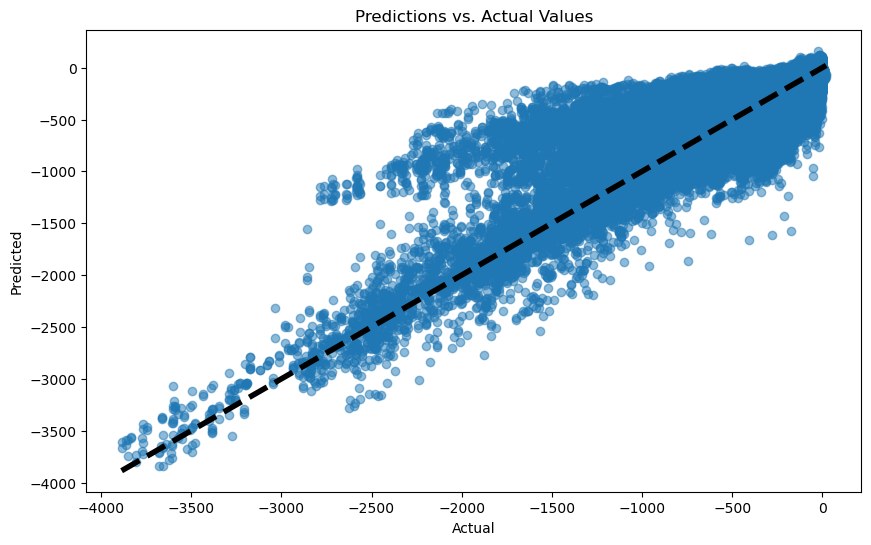

In [10]:
file_path = './data/validation_data/learning_all_moves.csv'
df = pd.read_csv(file_path, index_col='iteration')

groups = df['orig_ds_id']
print(f'Are present {len(groups.unique())} different datasets')
data = df.drop(COLS_TO_DROP, axis=1)

features = data.values
labels = df[TARGET_COL].values

# scaler = StandardScaler()
scaler = RobustScaler()
features_scaled = scaler.fit_transform(features)

features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

new_dataset = TensorDataset(features_tensor, labels_tensor)
new_loader = DataLoader(dataset=new_dataset, batch_size=BATCH_SIZE)
	
model.eval()  
with torch.no_grad():
	predictions = []
	actuals = []
	for X_batch, y_batch in new_loader:
		y_pred = model(X_batch)
		predictions.append(y_pred.numpy())
		actuals.append(y_batch.numpy())
		# Flatten the outputs and labels
		#predictions.extend(y_pred.detach().numpy().flatten())
		#actuals.extend(y_batch.numpy().flatten())

	# Flatten the list if predictions and actuals are nested lists
	predictions = np.concatenate(predictions, axis=0)
	actuals = np.concatenate(actuals, axis=0)
	#predictions = np.array(predictions)
	#actuals = np.array(actuals)


	plot_prediction(actuals, predictions)